# Imports / data cleanse

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer,make_column_transformer,make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
df = pd.read_csv('data/sales_predictions.csv')
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
df.drop_duplicates;

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [6]:
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [7]:
df['Item_Fat_Content'].replace('LF', 0, inplace=True)
df['Item_Fat_Content'].replace('low fat', 0, inplace=True)
df['Item_Fat_Content'].replace('Low Fat', 0, inplace=True)
df['Item_Fat_Content'].replace('Regular', 1, inplace=True)
df['Item_Fat_Content'].replace('reg', 1, inplace=True)

In [8]:
df['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

In [9]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [10]:
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [11]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [12]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [13]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

# LinearRegression

In [14]:
y = df['Item_Outlet_Sales']
X = df.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Outlet_Identifier'])

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,7.220,1,0.064142,Baking Goods,61.2510,1998,NaN,Tier 3,Grocery Store
7604,6.135,0,0.079294,Soft Drinks,111.2860,2009,Medium,Tier 3,Supermarket Type2
2762,12.150,0,0.028593,Household,151.0708,2004,Small,Tier 2,Supermarket Type1
6464,5.945,0,0.093009,Household,127.8652,2004,Small,Tier 2,Supermarket Type1
4707,18.200,1,0.066285,Fruits and Vegetables,247.2092,2004,Small,Tier 2,Supermarket Type1


In [15]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000279F0B12340>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000279F0B00DF0>)],
                  verbose_feature_names_out=False)

In [16]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.0,0.061531,132.2968,2007.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.85,0.0,0.044463,127.1020,1997.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.27,0.0,0.071078,114.2518,1997.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
y_test.head(3)

8077    1696.4584
2391    2024.0320
163     2618.5914
Name: Item_Outlet_Sales, dtype: float64

In [18]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [19]:
## fitting a linear regression model
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(n_jobs=-1)
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


In [20]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

In [21]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

intercept                         -72488.559968
Outlet_Type_Grocery Store          -1526.495324
Outlet_Type_Supermarket Type2       -467.752763
Outlet_Size_MISSING                 -315.271741
Item_Visibility                     -276.611557
Outlet_Location_Type_Tier 3         -199.714575
Outlet_Size_Small                   -158.679763
Outlet_Size_Medium                  -140.984136
Item_Type_Soft Drinks               -117.855877
Outlet_Type_Supermarket Type1        -97.390427
Item_Type_Household                  -68.642003
Item_Type_Dairy                      -48.843381
Item_Type_Health and Hygiene         -41.499603
Item_Type_Meat                       -15.912070
Item_Type_Snack Foods                -11.702918
Item_Type_Frozen Foods                -5.407801
Item_Type_Breads                      -4.092190
Item_Weight                            1.067856
Item_Type_Baking Goods                 8.977393
Item_MRP                              15.601944
Item_Type_Fruits and Vegetables       16

In [22]:
lin_reg.feature_names_in_

array(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [23]:
## Saving the coefficients
coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
coeffs['intercept'] = lin_reg.intercept_
coeffs

Item_Weight                            1.067856
Item_Fat_Content                      31.376589
Item_Visibility                     -276.611557
Item_MRP                              15.601944
Outlet_Establishment_Year             36.382100
Item_Type_Baking Goods                 8.977393
Item_Type_Breads                      -4.092190
Item_Type_Breakfast                   69.884397
Item_Type_Canned                      22.600329
Item_Type_Dairy                      -48.843381
Item_Type_Frozen Foods                -5.407801
Item_Type_Fruits and Vegetables       16.173621
Item_Type_Hard Drinks                 49.135252
Item_Type_Health and Hygiene         -41.499603
Item_Type_Household                  -68.642003
Item_Type_Meat                       -15.912070
Item_Type_Others                      17.607098
Item_Type_Seafood                     98.500490
Item_Type_Snack Foods                -11.702918
Item_Type_Soft Drinks               -117.855877
Item_Type_Starchy Foods               31

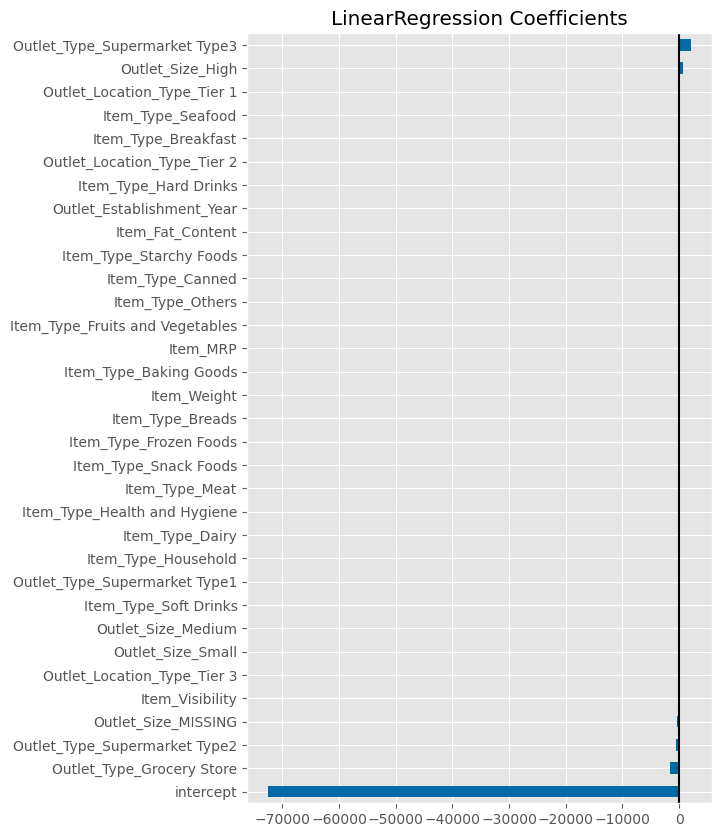

In [24]:
## Plot the coefficients
ax = coeffs.sort_values().plot(kind='barh',figsize=(6,10))
ax.axvline(0,color='k')
ax.set_title('LinearRegression Coefficients');

In [25]:
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
coeff_rank

intercept                          33.0
Outlet_Type_Supermarket Type3      32.0
Outlet_Type_Grocery Store          31.0
Outlet_Size_High                   30.0
Outlet_Type_Supermarket Type2      29.0
Outlet_Size_MISSING                28.0
Item_Visibility                    27.0
Outlet_Location_Type_Tier 3        26.0
Outlet_Size_Small                  25.0
Outlet_Location_Type_Tier 1        24.0
Outlet_Size_Medium                 23.0
Item_Type_Soft Drinks              22.0
Item_Type_Seafood                  21.0
Outlet_Type_Supermarket Type1      20.0
Item_Type_Breakfast                19.0
Item_Type_Household                18.0
Outlet_Location_Type_Tier 2        17.0
Item_Type_Hard Drinks              16.0
Item_Type_Dairy                    15.0
Item_Type_Health and Hygiene       14.0
Outlet_Establishment_Year          13.0
Item_Fat_Content                   12.0
Item_Type_Starchy Foods            11.0
Item_Type_Canned                   10.0
Item_Type_Others                    9.0


In [26]:
top_n_features = coeff_rank.head(10)
top_n_features

intercept                        33.0
Outlet_Type_Supermarket Type3    32.0
Outlet_Type_Grocery Store        31.0
Outlet_Size_High                 30.0
Outlet_Type_Supermarket Type2    29.0
Outlet_Size_MISSING              28.0
Item_Visibility                  27.0
Outlet_Location_Type_Tier 3      26.0
Outlet_Size_Small                25.0
Outlet_Location_Type_Tier 1      24.0
dtype: float64

In [27]:
## Slicing out the top_n_features names to visualize
plot_vals = coeffs.loc[top_n_features.index]
plot_vals

intercept                       -72488.559968
Outlet_Type_Supermarket Type3     2091.638514
Outlet_Type_Grocery Store        -1526.495324
Outlet_Size_High                   614.935639
Outlet_Type_Supermarket Type2     -467.752763
Outlet_Size_MISSING               -315.271741
Item_Visibility                   -276.611557
Outlet_Location_Type_Tier 3       -199.714575
Outlet_Size_Small                 -158.679763
Outlet_Location_Type_Tier 1        149.026038
dtype: float64

In [28]:
top_n = 3
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals


intercept                       -72488.559968
Outlet_Type_Grocery Store        -1526.495324
Outlet_Type_Supermarket Type3     2091.638514
dtype: float64

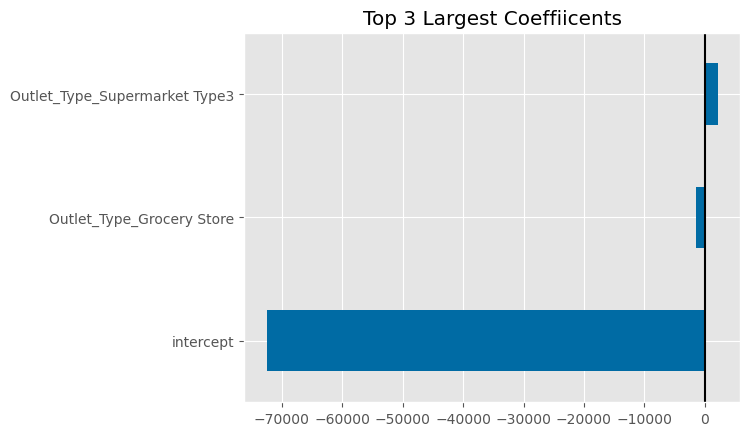

In [29]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
ax.set_title(f'Top {top_n} Largest Coeffiicents');

In [30]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    # Annotate the coefficients
    
    for bar in ax.patches:
    # Calculate bar center
        bar_ax = bar.get_y() + bar.get_height()/2
    # Get the value to annotate
        val = bar.get_width()

        val_pos = 0 if val < 0 else val

        ax.annotate(f"{val:.3f}", 
                (val, bar_ax),
                ha="left",
                va="center",
                xytext=(10, 0),
                size=10,
                textcoords="offset points")
    
        ax.set(xlabel='Coefficients',
           ylabel='Feature Names',
           title='Top 3 Linear Regression Coefficients');
    
    ## return ax in case want to continue to update/modify figure
    return ax

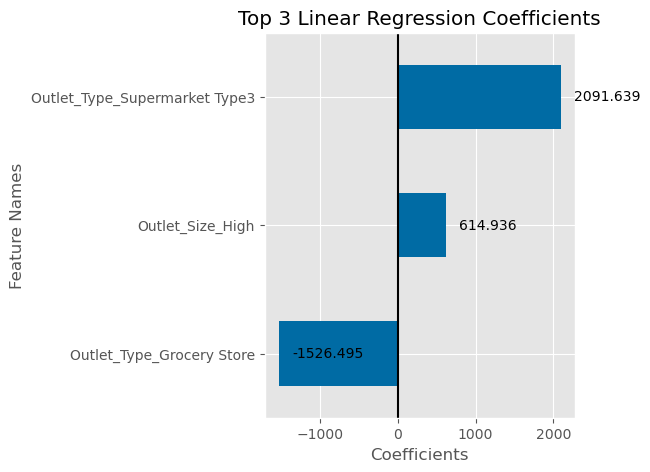

In [31]:
## Testing our function with intercept=False (the default)
ax= plot_coeffs(coeffs,top_n=3)

- If the store is classified as Outlet_Type_Supermarket Type3, the model will increase Item_Outlet_Sales by $2091.64

- If the store is classified as Outlet_Size_High, the model will increase the Item_Outlet_Sales by $614.94

- If the store is classified as Outlet_Type_Grocery Store, the model will decrease the Item_Outlet_Sales by $1526.50

# Tree-Based Model

In [32]:
# Instantiate the decision tree
dec_tree = DecisionTreeRegressor(max_depth=5, random_state=42)
# Fit the Decision tree model
dec_tree.fit(X_train_df, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

In [33]:
evaluate_regression(dec_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.61	RMSE= 1060.14
Test Data:	R^2= 0.59	RMSE= 1123.58


In [34]:
from sklearn.inspection import permutation_importance

r = permutation_importance(dec_tree, X_train_df, y_train ,n_repeats =5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [35]:
perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
perm_importances.head()

Item_Weight                  0.000022
Item_Fat_Content             0.000045
Item_Visibility              0.000331
Item_MRP                     0.750640
Outlet_Establishment_Year    0.007477
Name: permutation importance, dtype: float64

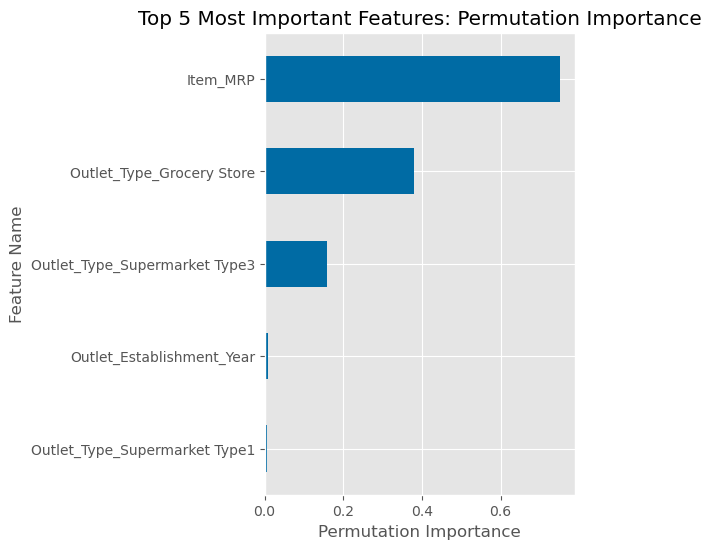

In [36]:
ax = perm_importances.sort_values().tail(5).plot(kind='barh',figsize=(4,6))
ax.set(ylabel='Feature Name',xlabel='Permutation Importance',
       title='Top 5 Most Important Features: Permutation Importance');

In [37]:
# Create a dictionary to export
export = {
    "preprocessor": preprocessor,
    "X_train": X_train_df,
    "X_test": X_test_df,
    "y_train": y_train,
    "y_test": y_test,
    "LinearRegression": lin_reg,
    "DecisionTreeRegressor": dec_tree
}
# Export th dictionary to a file
joblib.dump(export, "best-models.joblib")

['best-models.joblib']